In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import xesmf
import cf_xarray
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
obc_ds = xr.open_dataset('/g/data/w40/rl5183/obscount_20CRv3_rg.nc')
obc_data = obc_ds.obcount

In [3]:
obc_data

<xarray.DataArray 'obcount' (time: 2520, lat: 90, lon: 180)>
[40824000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-14 1806-02-14 ... 2015-12-14
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Attributes:
    units:    Number of Station Observations used in 2x2 degree bin

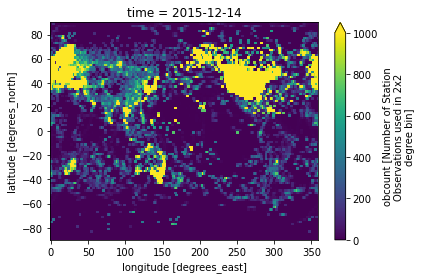

In [6]:
obc_data.sel(time='2015-12').plot(vmax=1000)

In [7]:
# Isolate the horn of africa (0-10N, 40-50E )
horn = obc_data.sel(lat=slice(-1,11)).sel(lon=slice(37,51))
horn

<xarray.DataArray 'obcount' (time: 2520, lat: 7, lon: 7)>
[123480 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-14 1806-02-14 ... 2015-12-14
  * lon      (lon) float64 38.0 40.0 42.0 44.0 46.0 48.0 50.0
  * lat      (lat) float64 -1.0 1.0 3.0 5.0 7.0 9.0 11.0
Attributes:
    units:    Number of Station Observations used in 2x2 degree bin

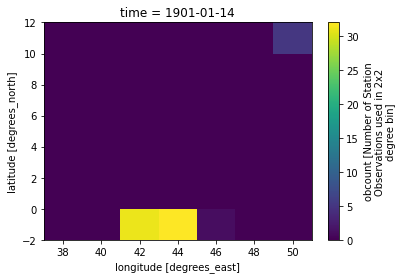

In [8]:
horn.sel(time='1901-01').plot()

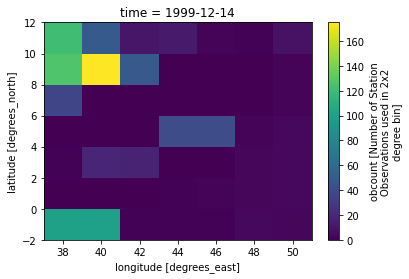

In [9]:
horn.sel(time='1999-12').plot()

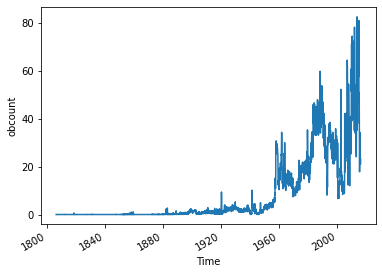

In [10]:
horn.mean(dim=['lat', 'lon']).plot()

In [11]:
# Isolate south east australia (30-40S, 140,150 
SE_aus = obc_data.sel(lat=slice(-41,-29)).sel(lon=slice(139,153))
SE_aus

<xarray.DataArray 'obcount' (time: 2520, lat: 7, lon: 7)>
[123480 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-14 1806-02-14 ... 2015-12-14
  * lon      (lon) float64 140.0 142.0 144.0 146.0 148.0 150.0 152.0
  * lat      (lat) float64 -41.0 -39.0 -37.0 -35.0 -33.0 -31.0 -29.0
Attributes:
    units:    Number of Station Observations used in 2x2 degree bin

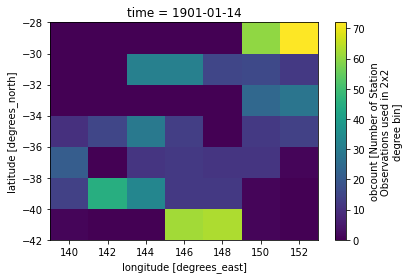

In [12]:
SE_aus.sel(time='1901-01').plot()

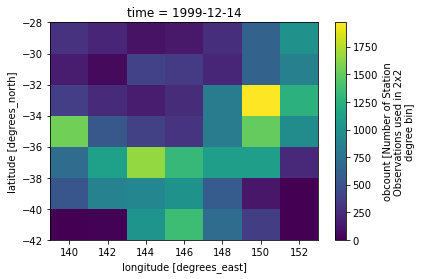

In [13]:
SE_aus.sel(time='1999-12').plot()

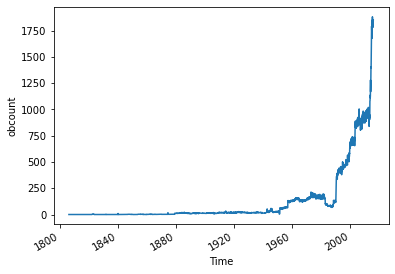

In [14]:
SE_aus.mean(dim=['lat', 'lon']).plot()

### Compare with HDI

In [15]:
hdi_ds = xr.open_dataset('/g/data/w40/rl5183/HDI_1990_2015_2x2.nc')

In [16]:
hdi = hdi_ds.HDI.sel(time='2015')

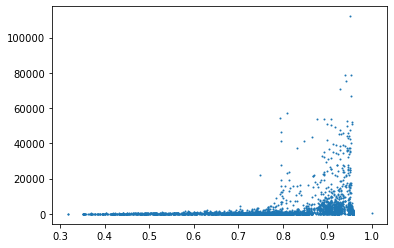

In [17]:
plt.scatter(hdi, obc_data.sel(time='2015-12'), s=1)

In [18]:
# Just look at regions with HDI <0.7
hdi_low = hdi.where(hdi<0.7)

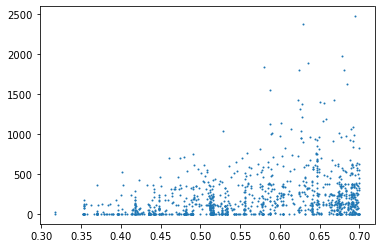

In [19]:
plt.scatter(hdi_low, obc_data.sel(time='2015-12'), s=1)

In [20]:
hdi_test = hdi.where(hdi_low>0.65)
obc_data_2015 = obc_data.sel(time='2015-12')
obc_data_test = obc_data_2015.where(obc_data_2015<500)

In [21]:
mask = obc_data_test * hdi_low

In [22]:
obc_mask = obc_data_test.where(np.isfinite(mask))
hdi_mask = hdi_test.where(np.isfinite(mask))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


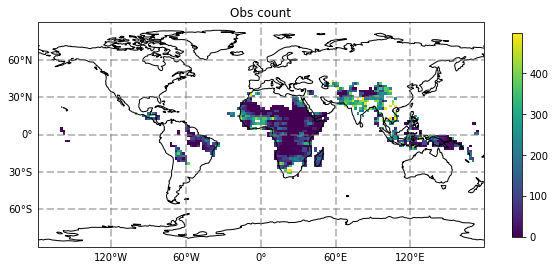

In [23]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
C = obc_mask.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('Obs count')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

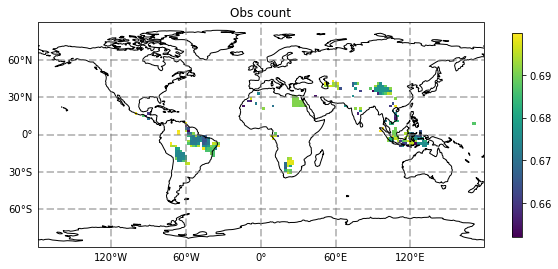

In [24]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
C = hdi_mask.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('Obs count')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

### Compare obs count with uncertainty

In [25]:
tmp_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/tmp_ensemble_std_corr_1901_2015.nc')
pr_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/prate_ensemble_std_corr_1901_2015.nc')

In [26]:
# Regrid on a 2x2
ds_bnds = tmp_ds.cf.add_bounds(['latitude','longitude'])
sample_bnds = obc_ds.cf.add_bounds(['lon','lat'])

In [27]:
regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')

In [28]:
tmp_data = tmp_ds.__xarray_dataarray_variable__
pr_data = pr_ds.__xarray_dataarray_variable__

In [29]:
tmp = regrid(tmp_data)
pr = regrid(pr_data)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [30]:
obc_data

<xarray.DataArray 'obcount' (time: 2520, lat: 90, lon: 180)>
[40824000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-14 1806-02-14 ... 2015-12-14
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Attributes:
    units:    Number of Station Observations used in 2x2 degree bin

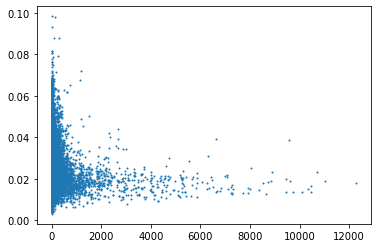

In [31]:
plt.scatter(obc_data.sel(time='2000-12'), tmp.sel(month=11), s=1)

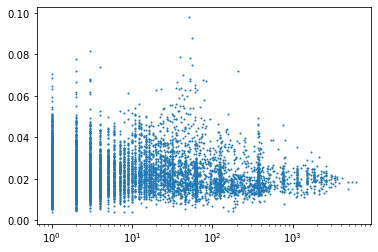

In [32]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(obc_data.sel(time='1950-12'), tmp.sel(month=11), s=1)
ax.set_xscale('log')

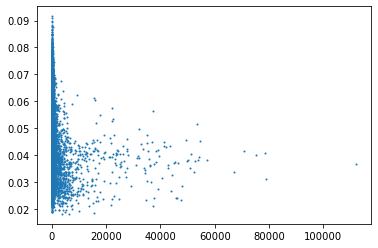

In [33]:
plt.scatter(obc_data.sel(time='2015-12'), pr.sel(month=11), s=1)

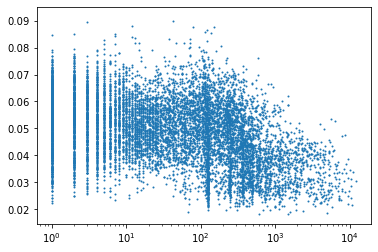

In [34]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(obc_data.sel(time='2000-12'), pr.sel(month=11), s=1)
ax.set_xscale('log')

In [35]:
# Mask out regions where correlation is moderate to strong ??

In [36]:
corr = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members.nc')
corr=regrid(corr)
corr_em = corr.sel(month=11).mean(dim='member')
corr_em_mask = corr_em.where((corr_em>0.2) | (corr_em<-0.2))

In [37]:
all_mask = hdi * corr_em_mask * obc_data_2015

In [39]:
hdi_mask = hdi.where(np.isfinite(all_mask))
obc_mask = obc_data_2015.where(np.isfinite(all_mask))

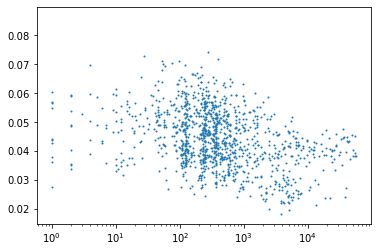

In [40]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(obc_mask, pr.sel(month=11), s=1)
ax.set_xscale('log')